# Svenskt Kvinnobiografiskt lexikon part 3
    version part 3 - 2.02  
  * get statistics SKBL and compare with SBL
  * check diff Wikidata SKBL

* Links 
  * this [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) 
  * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) check Wikidata and SKBL
  * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) more queries etc.
  * [part 4](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%204.ipynb) get archives
  * [part 5](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%205.ipynb) check Uppsala University Alvin
  * [SKBL issue board](https://github.com/spraakbanken/skbl-portal/issues) on GitHub
    * open [SKBL 23](https://github.com/spraakbanken/skbl-portal/issues/23)
* [video](https://www.youtube.com/watch?v=6jxH8MBIhvg) in Swedish about how SKBL deliver and work with Wikidata
  * Example how project Women in Red at en:Wikipedia automatic [creates list](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) that shows what in SKBL has an english article about a women but not have an english article in en:Wikipedia
    * see [version history](https://en.wikipedia.org/w/index.php?title=Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW&action=history) of list created
    * see en:Wikipedia articles [with a link to SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 680 articles

Below we get SKBL, SBL and Wikidata to create some statistics

**See also**
* video [Introduction to Wikidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

# Wikidata - WDSKBLtot

In [1]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-09-18 09:33:33.826802


In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?skblid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSKBLtot = get_sparql_dataframe(endpoint_url, querySKBL)
WDSKBLtot["Source"] = "SKBL" 


In [3]:
WDSKBLtot.sort_index(inplace=True)  

In [4]:
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wid     1501 non-null   object
 1   skblid  1501 non-null   object
 2   Source  1501 non-null   object
dtypes: object(3)
memory usage: 35.3+ KB


## Get SKBL records - SKBLtot

In [5]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None)
pd.set_option('display.max_rows', None)

  
#Ny bättre URL    
url = "https://ws.spraakbanken.gu.se/ws/karp/v5/query?mode=skbl&q=extended%7C%7Cand%7Cskblstatus%7Cequals%7Cok&size=10000"
r = http.request('GET', url) 
data = json.loads(r.data.decode('utf-8')) 
#print(type(data))
#print(r.info())  

listSKBL = []
i = 0 
for row in (data["hits"]["hits"]):
    #print (row["_source"]["url"])
    new_item = dict()
    new_item['skblid'] = row["_source"]["url"]
   
    try:
        publishedDate = row["_source"]['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = row["_source"]["article_author"][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = row["_source"]["article_author"][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = row["_source"]['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        name_lastname = row["_source"]['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = row["_source"]['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    listSKBL.append(new_item)
    i = i + 1 
    #print (i)
print (len(listSKBL) ," antal poster")


1502  antal poster


In [6]:
SKBLtot = pd.DataFrame(listSKBL,
                  columns=['skblid','publishedDate','article_author_firstname','article_author_lastname',
                          'subtitle_sv','name_lastname','name_firstname'])

In [7]:
SKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   skblid                    1502 non-null   object
 1   publishedDate             1502 non-null   object
 2   article_author_firstname  1502 non-null   object
 3   article_author_lastname   1502 non-null   object
 4   subtitle_sv               1502 non-null   object
 5   name_lastname             1502 non-null   object
 6   name_firstname            1502 non-null   object
dtypes: object(7)
memory usage: 82.3+ KB


In [8]:
SKBLtot["publishedDate"] = SKBLtot["publishedDate"].astype("datetime64")
SKBLtot["Source"] = "SKBL"

In [9]:
%matplotlib inline    
import matplotlib.pyplot as plt   


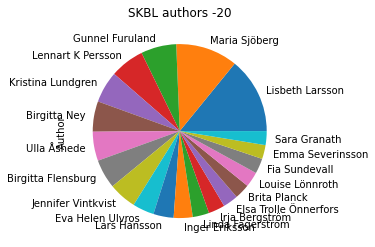

In [10]:
plotPublishedAuthor = SKBLtot  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors -20")
plt.show()

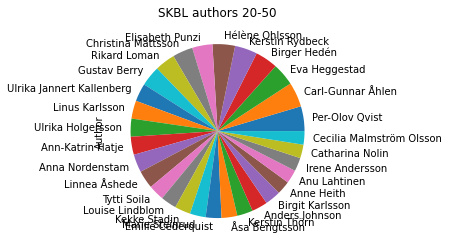

In [11]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors 20-50")
plt.show()

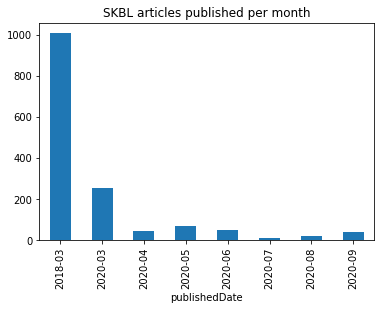

In [12]:
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = SKBLtot['publishedDate'].groupby(SKBLtot.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.title("SKBL articles published per month")
plt.show()

In [13]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      38
Freq: M, Name: publishedDate, dtype: int64

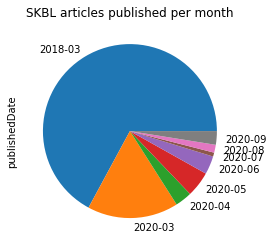

In [14]:
plotPublishedperMonth.plot( kind = 'pie') 
plt.title("SKBL articles published per month")
plt.show()

In [15]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
#dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

In [16]:
from IPython.display import display, HTML  
plotPublishedAuthor['Link'] = plotPublishedAuthor['skblid'].apply(lambda x: "https://skbl.se/sv/artikel/{0}".format(x))  
plotPublishedAuthor.style.set_properties(subset=['publishedDate'], **{'width': '200px'}) 

# Merge plotPublishedAuthor WDSKBLtot  
mergeSKBLWD = pd.merge(WDSKBLtot, plotPublishedAuthor,how='outer', on='skblid',indicator=True)   
mergeSKBLWD.rename(columns={"_merge": "WD_SKBL"},inplace = True)
mergeSKBLWD['WD_SKBL'] = mergeSKBLWD['WD_SKBL'].str.replace('left_only','WD_only').str.replace('right_only','SKBL_only')
mergeSKBLWD["WD_SKBL"].value_counts()  


both         1501
SKBL_only       1
Name: WD_SKBL, dtype: int64

### Latest articles in SKBL

In [17]:
# de sista 10 publiserade biografier 
mergeSKBLWD = mergeSKBLWD.sort_values(by=['publishedDate'], ascending=[False])
mergeSKBLWD = mergeSKBLWD.reset_index(drop=True)  

mergeSKBLWD[:10]

,wid,skblid,Source_x,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,name_lastname,name_firstname,Source_y,Author,Link,WD_SKBL
0,Q4989633,JosephineGabrielleMarcelleMeunierSainteClaire,SKBL,2020-09-18,Eva Helen,Ulvros,"Dansare, koreograf",Sainte-Claire,/Joséphine/ Gabrielle Marcelle Meunier,SKBL,Eva Helen Ulvros,https://skbl.se/sv/artikel/JosephineGabrielleM...,both
1,NaN,IdaEleonoraDavidavonSchulzenheim,NaN,2020-09-18,Ulla,Åshede,Konstnär,von Schulzenheim,/Ida/ Eleonora Davida,SKBL,Ulla Åshede,https://skbl.se/sv/artikel/IdaEleonoraDavidavo...,SKBL_only
2,Q99428948,CeciliaAnderson,SKBL,2020-09-17,Hege,Vårdal,"Entomolog, pionjär, globetrotter",Anderson,/Cecilia/,SKBL,Hege Vårdal,https://skbl.se/sv/artikel/CeciliaAnderson,both
3,Q18242858,HedvigIndebetou,SKBL,2020-09-17,Kristina,Lauridsen,"Författare, dramatiker, översättare",Indebetou,/Hedvig/ Sofia Amalia,SKBL,Kristina Lauridsen,https://skbl.se/sv/artikel/HedvigIndebetou,both
4,Q161133,Annadrottning,SKBL,2020-09-16,Jenny,Öhman,Drottning av Sverige och Polen,,"/Anna/, drottning",SKBL,Jenny Öhman,https://skbl.se/sv/artikel/Annadrottning,both
5,Q16946278,GretaHammarsten,SKBL,2020-09-16,Michaela,Malmberg,"Läkare, biokemist, pionjär",Hammarsten,/Greta/,SKBL,Michaela Malmberg,https://skbl.se/sv/artikel/GretaHammarsten,both
6,Q53594431,LisbethRenner,SKBL,2020-09-16,Ulrika,Jannert Kallenberg,Översättare,Renner,/Lisbeth/,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/LisbethRenner,both
7,Q24680682,WendelaLovisaUlrikaAnderssonFalck,SKBL,2020-09-16,Hans,Bolling,"Konstnär, illustratör, gymnastiklärare",Andersson-Falck,/Wendela/ Lovisa Ulrika,SKBL,Hans Bolling,https://skbl.se/sv/artikel/WendelaLovisaUlrika...,both
8,Q19975954,KarinGunnelIngegerdEriksson,SKBL,2020-09-15,Kerstin,Thörn,"Bibliotekarie, länsantikvarie",Eriksson,/Karin/ Gunnel Ingegerd,SKBL,Kerstin Thörn,https://skbl.se/sv/artikel/KarinGunnelIngegerd...,both
9,Q4989368,KerstinBirgittaNordenstam,SKBL,2020-09-15,Anna,Nordenstam,"Lektor, språkforskare, genusforskningspionjär",Nordenstam,/Kerstin/ Birgitta,SKBL,Anna Nordenstam,https://skbl.se/sv/artikel/KerstinBirgittaNord...,both


## Compare SBL
SBL started in 1918 and is published by the [National Archives](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) in Sweden. They have
* No API
* focus on publish on paper
* dont have structured data
* no understanding of [Linked data](https://vimeo.com/36752317)
* we have before manually and doing webscrabing populated [Wikidata P3217](https://www.wikidata.org/wiki/Property_talk:P3217) now I guess we wait on SBL for delivering data as data see question asked [236883](https://phabricator.wikimedia.org/T236883) Oct 30 2019, 11:03 AM - no official answer so far and The Swedish National Archives has no helpdesk system were you get an unique helpdesk number ([some action was promised aug 2018 by Rolf Källman](https://twitter.com/salgo60/status/1030269242296414208?s=20) nothing heard)

### Wikidata <-> SBL updated
We did a NEW try getting structure from webscrabed data see [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)

In [18]:
# SPARQL 
querySBL = """SELECT distinct (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid  ?skblid ?genderLabel  WHERE {
?item wdt:P31 wd:Q5.
OPTIONAL {?item wdt:P21 ?gender}
?item wdt:P3217 ?sblid
OPTIONAL {?item wdt:P4963 ?skblid}
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} order by ?sblid """


WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)
WDSBLtot["Source"] = "SBL" 
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7599 non-null   object
 1   sblid        7599 non-null   object
 2   skblid       334 non-null    object
 3   genderLabel  7599 non-null   object
 4   Source       7599 non-null   object
dtypes: object(5)
memory usage: 297.0+ KB


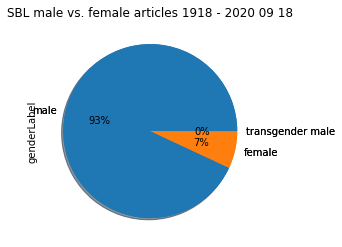

In [19]:
plotSBLgender = WDSBLtot["genderLabel"].value_counts()
plotSBLgender.plot( kind = 'pie') 
plt.title("Riksarkivet SBL male/female")
plot = plotSBLgender.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL male vs. female articles 1918 - " + start_time.strftime('%Y %m %d'))

plt.show()

In [20]:
plotSBLgender

male                7071
female               527
transgender male       1
Name: genderLabel, dtype: int64

In [21]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7599 non-null   object
 1   sblid        7599 non-null   object
 2   skblid       334 non-null    object
 3   genderLabel  7599 non-null   object
 4   Source       7599 non-null   object
dtypes: object(5)
memory usage: 297.0+ KB


In [22]:
WDSBLtot[WDSBLtot.duplicated(subset=['wid'])]

,wid,sblid,skblid,genderLabel,Source


In [23]:
plotSBLgender

male                7071
female               527
transgender male       1
Name: genderLabel, dtype: int64

In [24]:
plotSBLfemale = WDSBLtot[WDSBLtot["genderLabel"] == "female"] 
#plotSBLfemale["birth"] = plotSBLfemale["birth"].astype("datetime64")
plotSBLfemale.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 7 to 7580
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          527 non-null    object
 1   sblid        527 non-null    object
 2   skblid       333 non-null    object
 3   genderLabel  527 non-null    object
 4   Source       527 non-null    object
dtypes: object(5)
memory usage: 24.7+ KB


In [25]:
#Merge mergeSKBLWD and plotSBLfemale 


In [26]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-09-18 09:33:48.251022


In [27]:
dfmerge = pd.merge(plotSBLfemale, mergeSKBLWD,how='outer', on='wid',indicator=True)

In [28]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 1695
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   wid                       1695 non-null   object        
 1   sblid                     527 non-null    object        
 2   skblid_x                  333 non-null    object        
 3   genderLabel               527 non-null    object        
 4   Source                    527 non-null    object        
 5   skblid_y                  1502 non-null   object        
 6   Source_x                  1501 non-null   object        
 7   publishedDate             1502 non-null   datetime64[ns]
 8   article_author_firstname  1502 non-null   object        
 9   article_author_lastname   1502 non-null   object        
 10  subtitle_sv               1502 non-null   object        
 11  name_lastname             1502 non-null   object        
 12  name_firstname      

In [29]:
dfmerge["_merge"].value_counts()

right_only    1169
both           333
left_only      194
Name: _merge, dtype: int64

In [30]:
# both is number in bioth SBL and SKBL   
# right_only is SBL
# left_only is SKBL

In [31]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','SBL_only').str.replace('right_only','SKBL_only')
dfmerge.rename(columns={"_merge": "SBL_SKBL"},inplace = True)

dfmerge[0:10]  


,wid,sblid,skblid_x,genderLabel,Source,skblid_y,Source_x,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,name_lastname,name_firstname,Source_y,Author,Link,WD_SKBL,SBL_SKBL
0,Q1794132,10025,None,female,SBL,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
1,Q3431866,10043,MarianneLofgren,female,SBL,MarianneLofgren,SKBL,2018-03-08,Jennifer,Vintkvist,Skådespelare,Löfgren,Jeannette Wedday /Marianne/ Ida Carolina,SKBL,Jennifer Vintkvist,https://skbl.se/sv/artikel/MarianneLofgren,both,both
2,Q4964675,10125,HarrietLowenhjelm,female,SBL,HarrietLowenhjelm,SKBL,2018-03-08,Boel,Hackman,"Författare, konstnär",Löwenhjelm,/Harriet/ Augusta Dorothea,SKBL,Boel Hackman,https://skbl.se/sv/artikel/HarrietLowenhjelm,both,both
3,Q4942488,10132,None,female,SBL,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
4,Q4965144,10184,MathildaMalling,female,SBL,MathildaMalling,SKBL,2018-03-08,Birgitta,Ney,Författare,Malling,Ingrid /Mathilda/,SKBL,Birgitta Ney,https://skbl.se/sv/artikel/MathildaMalling,both,both
5,Q16595614,10248,None,female,SBL,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
6,Q4968661,10331,EbbaMansdotterLilliehook0,female,SBL,EbbaMansdotterLilliehook0,SKBL,2020-03-02,Jan,Samuelson,"Grevinna, godsägare",Månsdotter (Lilliehöök),/Ebba/,SKBL,Jan Samuelson,https://skbl.se/sv/artikel/EbbaMansdotterLilli...,both,both
7,Q16595619,10332,None,female,SBL,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
8,Q4962236,10390,FredrikaCatharinaLimnell,female,SBL,FredrikaCatharinaLimnell,SKBL,2020-03-02,Birgitta,Jordansson,"Kvinnosakskvinna, salongsvärdinna, mecenat",Limnell,/Fredrika/ Catharina,SKBL,Birgitta Jordansson,https://skbl.se/sv/artikel/FredrikaCatharinaLi...,both,both
9,Q42399094,10396,None,female,SBL,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only


In [32]:
mergeCheck = dfmerge[['wid', 'sblid','skblid_x','publishedDate','SBL_SKBL']] 
mergeCheck.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 1695
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            1695 non-null   object        
 1   sblid          527 non-null    object        
 2   skblid_x       333 non-null    object        
 3   publishedDate  1502 non-null   datetime64[ns]
 4   SBL_SKBL       1696 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 79.5+ KB


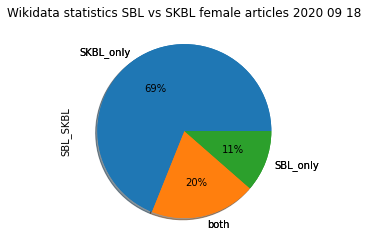

In [33]:
mergeCheckNumber = mergeCheck["SBL_SKBL"].value_counts()
mergeCheckNumber.plot( kind = 'pie')  
plot = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("Wikidata statistics SBL vs SKBL female articles " + start_time.strftime('%Y %m %d'))
plt.show()


In [34]:
mergeCheckNumber

SKBL_only    1169
both          333
SBL_only      194
Name: SBL_SKBL, dtype: int64

In [35]:
#Profiles missing in SKBL that SBL has written = left_only 
WDSBLonly = mergeCheck[mergeCheck["SBL_SKBL"] == "SBL_only"].copy() 

In [36]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 523
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            194 non-null    object        
 1   sblid          194 non-null    object        
 2   skblid_x       0 non-null      object        
 3   publishedDate  0 non-null      datetime64[ns]
 4   SBL_SKBL       194 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 9.1+ KB


In [37]:
WDSBLonly["sbl"] = "https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=" + WDSBLonly["sblid"] 
pd.set_option('column_space', 20)
pd.set_option('max_colwidth', 300)

WDSBLonly[["wid","sblid","sbl"]][:10]

,wid,sblid,sbl
0,Q1794132,10025,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10025
3,Q4942488,10132,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10132
5,Q16595614,10248,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10248
7,Q16595619,10332,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10332
9,Q42399094,10396,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10396
11,Q4767223,10404,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10404
12,Q4962366,10417,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10417
13,Q11857592,10445,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10445
22,Q38373456,10673,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10673
23,Q4963073,10728,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10728


### Same query in Wikidata 
* Find all women [in SBL but not in SKBL](https://w.wiki/bFw) < 196 women
* Find all women [in SBL but not in SKBL and have an en:Wikipedia article](https://w.wiki/bFy) < 128 
### Wikipedia articles linking SKBL 
* sv:Wikipedia [usage template Authority](https://sv.wikipedia.org/wiki/Kategori:Wikipediaartiklar_med_identifierare_fr%C3%A5n_SKBL) > 1410
  * **[Issue 23](https://github.com/spraakbanken/skbl-portal/issues/23)** SKBL has no date when the article is  translated maybe bad "workaround" is check tag **text_eng** that is missing in a non translated article as [JosephineGabrielleMarcelleMeunierSainteClaire.json](https://skbl.se/sv/artikel/JosephineGabrielleMarcelleMeunierSainteClaire.json) compare translated [article](https://skbl.se/sv/artikel/JennyLind.json) and then check that all articles with **text_eng** has [template SBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963)
* en:Wikipedia [usage template SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 686 articles


In [38]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 523
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            194 non-null    object        
 1   sblid          194 non-null    object        
 2   skblid_x       0 non-null      object        
 3   publishedDate  0 non-null      datetime64[ns]
 4   SBL_SKBL       194 non-null    object        
 5   sbl            194 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 10.6+ KB


In [39]:
dfmerge["SBL_SKBL"].value_counts()

SKBL_only    1169
both          333
SBL_only      194
Name: SBL_SKBL, dtype: int64

In [40]:
mergeSKBLWD["WD_SKBL"].value_counts() 

both         1501
SKBL_only       1
Name: WD_SKBL, dtype: int64

In [41]:
mergeSKBLWD[mergeSKBLWD["WD_SKBL"] == "SKBL_only"] 

,wid,skblid,Source_x,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,name_lastname,name_firstname,Source_y,Author,Link,WD_SKBL
1,NaN,IdaEleonoraDavidavonSchulzenheim,NaN,2020-09-18,Ulla,Åshede,Konstnär,von Schulzenheim,/Ida/ Eleonora Davida,SKBL,Ulla Åshede,https://skbl.se/sv/artikel/IdaEleonoraDavidavonSchulzenheim,SKBL_only


In [42]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-09-18 09:33:48.621487


In [43]:
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:14.802315
